# Imports and Constants

In [92]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.tsa.stattools as ts

from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

DATASET_PATH = 'electric_gas_utils.csv'

# Helper functions

In [94]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series", figsize=(20,4)):
    plt.figure(figsize=figsize)
    plt.plot(x, y, 'k-')
    plt.title(title)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);
    

def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

def dftest(timeseries):
    plt.figure(figsize=(20,4))
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)
    
def plots(data, lags=None):
    plt.figure(figsize=(20,6))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

# Data preprocessing
- Change datatypes
- Set index columns
- Remove duplicate rows
- Autocorrelation plots to check seasonality
- Stationarity check

Before:
DATE           object
IPG2211A2N    float64
dtype: object

After:
date    datetime64[ns]
ip             float64
dtype: object


,ip
date,
1990-01-01,83.2897
1990-02-01,76.1676
1990-03-01,72.2190
1990-04-01,66.3566
1990-05-01,64.9348


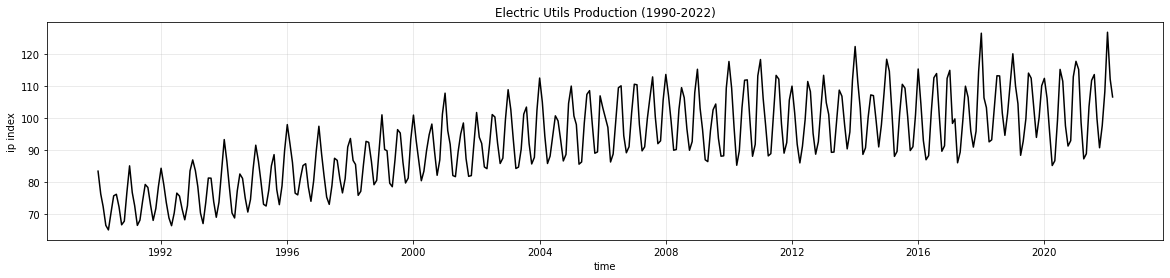

In [35]:
df = pd.read_csv(DATASET_PATH)
print('Before:')
print(df.dtypes)

df.rename(columns={'DATE': 'date', 'IPG2211A2N': 'ip'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
print('\nAfter:')
print(df.dtypes)

df.set_index(["date"], inplace=True)
df.drop_duplicates(inplace=True)


display(df.head())
run_sequence_plot(df.index, df.ip, title='Electric Utils Production (1990-2022)', ylabel='ip index')

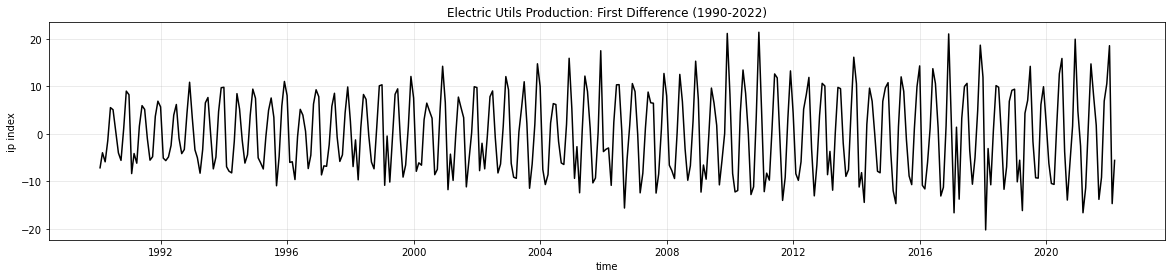

In [48]:
# removing trend
df['ip_first_diff'] = df['ip'].diff()
df.dropna(inplace=True)
run_sequence_plot(df.index, df.ip_first_diff, title='Electric Utils Production: First Difference (1990-2022)', ylabel='ip index')

Monthly data Autocorrelation Plots


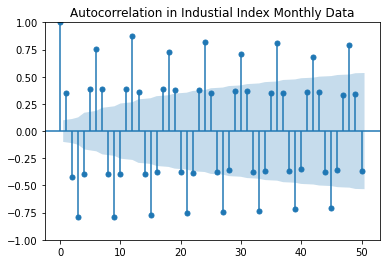

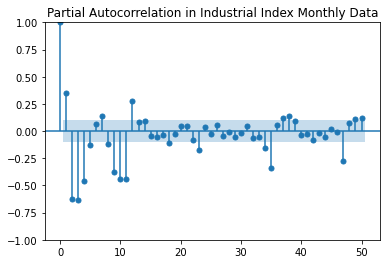

In [61]:
# autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

print('Monthly data Autocorrelation Plots')
acf_plot = plot_acf(df['ip_first_diff'], lags=50, title='Autocorrelation in Industial Index Monthly Data')
#plot_acf(sales_new['Sales']['Furniture'])
pacf_plot = plot_pacf(df['ip_first_diff'], lags=50, title='Partial Autocorrelation in Industrial Index Monthly Data')


Test Statistic         -7.873602e+00
p-value                 4.910504e-12
Lags Used               1.200000e+01
Observations Used       3.730000e+02
Critical Value (1%)    -3.448004e+00
Critical Value (5%)    -2.869320e+00
Critical Value (10%)   -2.570915e+00
dtype: float64


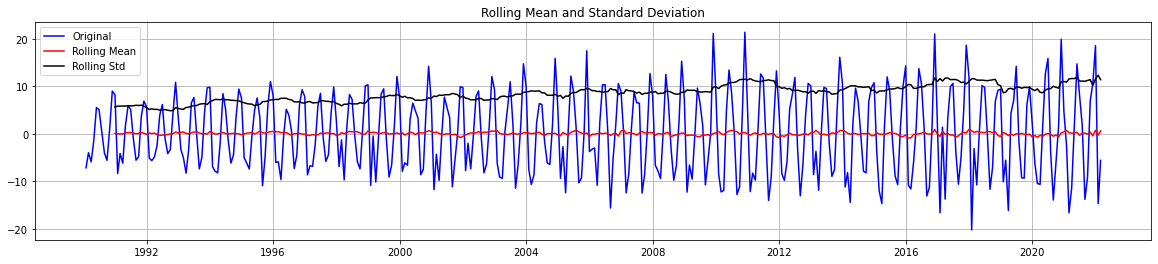

In [85]:
# stationarity checking
dftest(df.ip_first_diff)

# from statistics and graph we conclude that the data is stationary

# Time Series Analysis

## Triple Exponential Smoothing

MSE:  245.43802588895736


C:\Users\USER\anaconda3\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


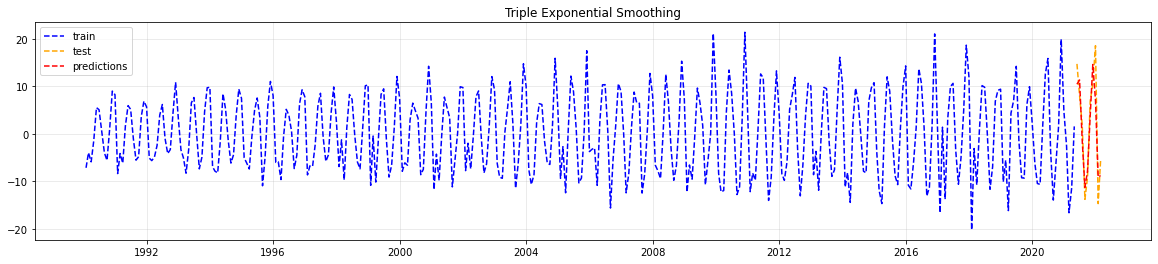

In [76]:
# Triple exponential smoothing)
from statsmodels.tsa.api import ExponentialSmoothing
time = df.index
train = df['ip_first_diff'][:-10]
test = df['ip_first_diff'][-10:]

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=12).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(np.array(test), np.array(triple_preds))
print("MSE: ", triple_mse)

plt.figure(figsize=(20,4))
plt.plot(time[:-10], train, 'b--', label="train")
plt.plot(time[-10:], test, color='orange', linestyle="--", label="test")
plt.plot(time[-10:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

## SARIMA

In [118]:
import statsmodels.api as sm
sar = sm.tsa.statespace.SARIMAX(df.ip_first_diff, 
                                order=(2,0,0), 
                                seasonal_order=(1,0,1,12), 
                                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        ip_first_diff   No. Observations:                  386
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -969.527
Date:                              Tue, 03 May 2022   AIC                           1951.055
Time:                                      18:53:20   BIC                           1974.790
Sample:                                  02-01-1990   HQIC                          1960.467
                                       - 03-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.010      0.055      0.957      -0.019       0.021
ar.L1         -0.3332      0.045     -7.327      0.000      -0.422      -0.244
ar.L2         -0.1965      0.045     -4.349      0.000      -0.285      -0.108
ar.S.L12       0.9973      0.003    390.364      0.000       0.992       1.002
ma.S.L12      -0.7659      0.038    -19.958      0.000      -0.841      -0.691
sigma2         8.0454      0.512     15.712      0.000       7.042       9.049
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                11.93
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               3.19   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

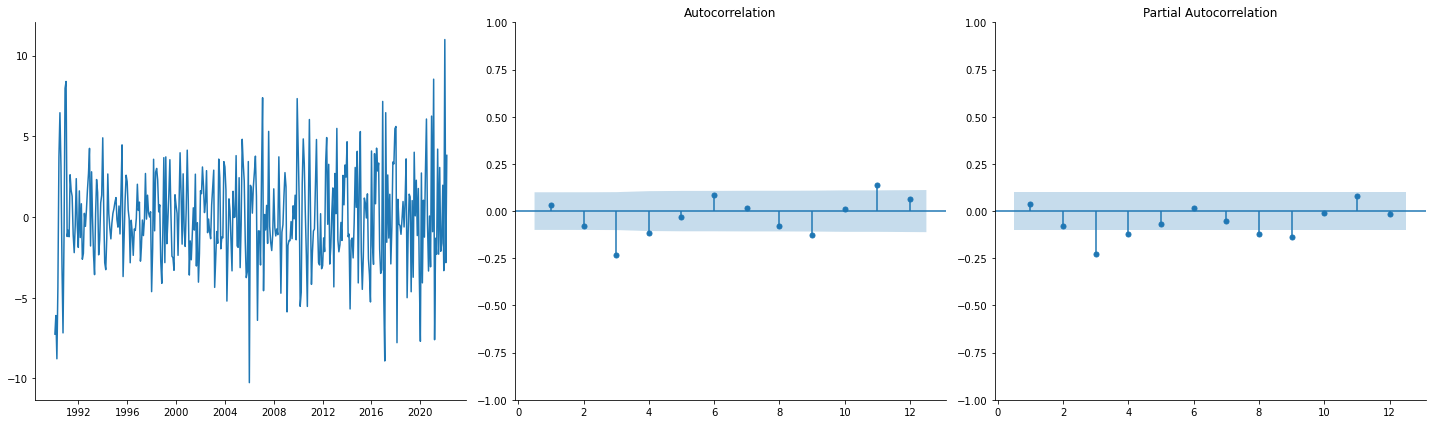

In [120]:
# plot resids
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

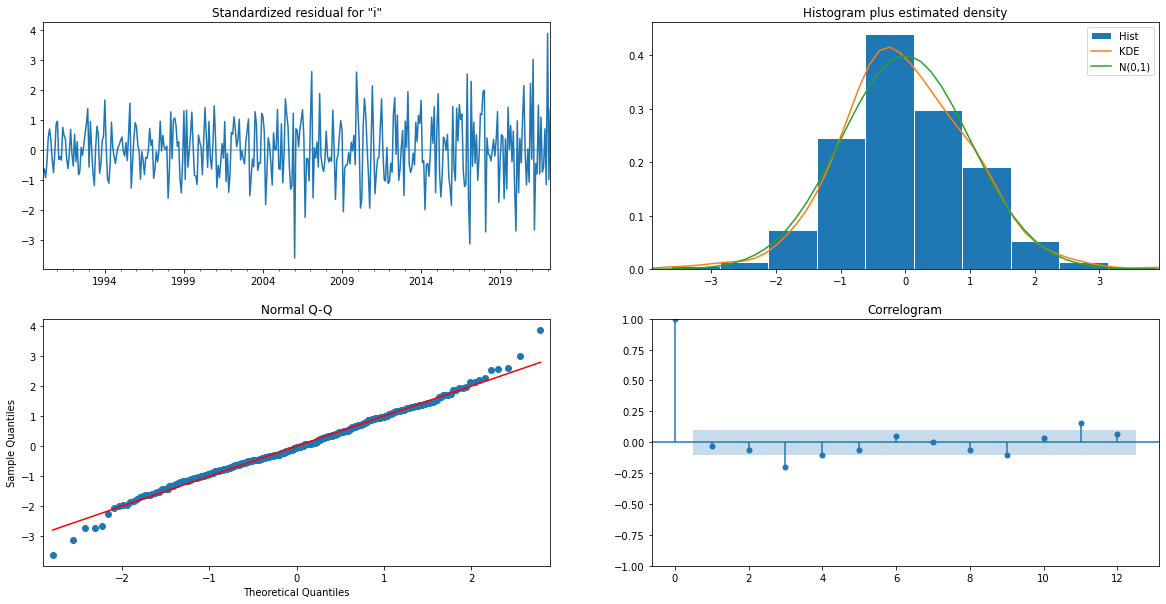

In [121]:
# plot residual diagnostics
sar.plot_diagnostics(lags=12,figsize = (20,10),);

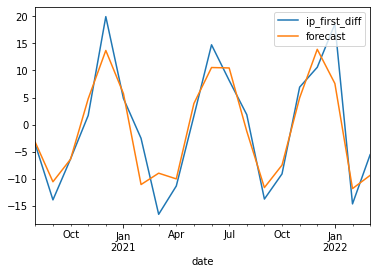

In [122]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
df['forecast'] = sar.predict(start = len(df)-20, end= len(df)-1)  
df[['ip_first_diff', 'forecast']][-20:].plot();